Este archivo principal une todos los módulos y ejecuta el entrenamiento, validación y evaluación del modelo GCN.

# Importar módulos

In [1]:

#Importamos los modulos necesarios

import torch
import numpy as np
from torch_geometric.loader import DataLoader
from Dataset_loader import PCBDataset  # Asegúrate que Dataset_loader se encuentra en el mismo directorio
from gcn_model import GCN
from data_loader import load_pcb_dataset
from train_eval import train, evaluate, plot_temperature_maps, standardize_data
from model_saver import save_model
import os

In [2]:
# Configuración del dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Usando dispositivo: {device}")

Usando dispositivo: cuda


## Configuración

In [ ]:
#Rellenar config

In [3]:
# Ruta al archivo de dataset
file_path = 'PCB_dataset.pth'  # Asegúrate que este archivo está en la carpeta actual

# Cargar el dataset y estandarizarlo automáticamente
graphs = standardize_data(load_pcb_dataset(file_path))  # Ahora la estandarización se realiza automáticamente

# Imprimir información del dataset
print(f"Dataset cargado correctamente. Número de gráficos: {len(graphs)}")
nodos_por_grafico = graphs[0].y.shape[0]  # Obtiene el número total de nodos por gráfico
print(f"Número de nodos por gráfico: {nodos_por_grafico}")



c:\Users\ramse\Escritorio\Aero Ordenador\4to Aero\2do Cuatri\Repo_TFG\ia_thermal\ernestoemedina\data_loader.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dataset = to

Dataset cargado correctamente. Número de gráficos: 20000
Número de nodos por gráfico: 169


In [4]:
# División del dataset
train_size = int(0.8 * len(graphs))
val_size = int(0.1 * len(graphs))
test_size = len(graphs) - train_size - val_size

train_dataset = graphs[:train_size]
val_dataset = graphs[train_size:train_size + val_size]
test_dataset = graphs[train_size + val_size:]

# Crear DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [5]:
# Definición del modelo
input_dim = 1  # Potencia como única característica de entrada
hidden_dim = 64
output_dim = 1  # Temperatura predicha por cada nodo
num_layers = 2


learning_rate = 0.001
epochs = 1

# Crear el modelo
model = GCN(input_dim, hidden_dim, output_dim, num_layers, use_dropout=True, dropout_rate=0.2,
                 use_batchnorm=True,
                 use_residual=True).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

print("Modelo creado correctamente.")


Modelo creado correctamente.


Ahora creamos un diccionario en el que metemos los parámetros de error que va a tener el modelo como referencia, tanto para el entrenamiento y validacion como para el test

In [6]:
# Diccionario de configuración para elegir el método de evaluación
config = {
    "use_percentage_threshold": False,  # Cambia a True si quieres usar porcentaje en lugar de Kelvin
    "error_threshold_K": 5.0,  # Umbral de error en Kelvin (si no se usa porcentaje)
    "percentage_threshold": 5.0  # Umbral de error en porcentaje (solo se usa si 'use_percentage_threshold' es True)
    # Ten en cuenta que el % no se mantiene al normalizar, es decir, lo que te pinta en train no es el accuracy real.
}


Ahora definimos los parámetros para guardar los modelos

In [7]:
# Configuración para el guardado de modelo

save_model_to_file = None  # Cambia a True si deseas guardar el modelo al final, ya sea el mejor o el último
use_memory_for_best_model = True  # Cambia a True si deseas mantener el mejor modelo en memoria durante el entrenamiento

best_model_state = None  # No cambiar, si se usa la opción 'use_memory_for_best_model' se guardará el mejor modelo aquí
best_loss = float('inf')  # Mejor pérdida inicial (infinito para asegurar que se guarda el primer modelo)



In [8]:
#Entrenamiento del modelo

print("Iniciando entrenamiento...")

for epoch in range(epochs):
    # Entrenamiento
    train_loss = train(model, train_loader, optimizer, device)
    
    # Evaluación
    if config["use_percentage_threshold"]:
        val_mse, val_mae, val_r2, val_accuracy = evaluate(
            model, test_loader, device, nodos_por_grafico=nodos_por_grafico,
            percentage_threshold=config["percentage_threshold"],
            plot_results=False,
            normalize=True
        )
    else:
        val_mse, val_mae, val_r2, val_accuracy = evaluate(
            model, test_loader, device, nodos_por_grafico=nodos_por_grafico,
            error_threshold=config["error_threshold_K"],
            plot_results=False,
            normalize=True
        )

    print(f"Epoch {epoch+1}/{epochs} - Loss: {train_loss:.4f} - Val MSE: {val_mse:.4f} - Val MAE: {val_mae:.4f} - Val R2: {val_r2:.4f} - Val Accuracy: {val_accuracy:.2f}%")

    # Guardar el mejor modelo en memoria si se ha habilitado
    if use_memory_for_best_model and train_loss < best_loss and epoch>epochs/2:      # Meter aqui un and epoch> tal para guardar a partir de X epochs
        best_loss = train_loss
        if best_model_state is None: # If Para acelerar el proceso
            best_model_state = {k: v.clone() for k, v in model.state_dict().items()} # Si no hay nada, se crea una copia completa
        else:
            for k, v in model.state_dict().items(): # Si ya hay algo, se actualiza
                best_model_state[k].copy_(v) 

        print(f"Nuevo mejor modelo guardado en memoria con Loss: {best_loss:.4f}")


Iniciando entrenamiento...
Epoch 1/1 - Loss: 0.4850 - Val MSE: 0.4961 - Val MAE: 0.5577 - Val R2: 0.0831 - Val Accuracy: 15.65%


Evaluando en el conjunto de prueba...


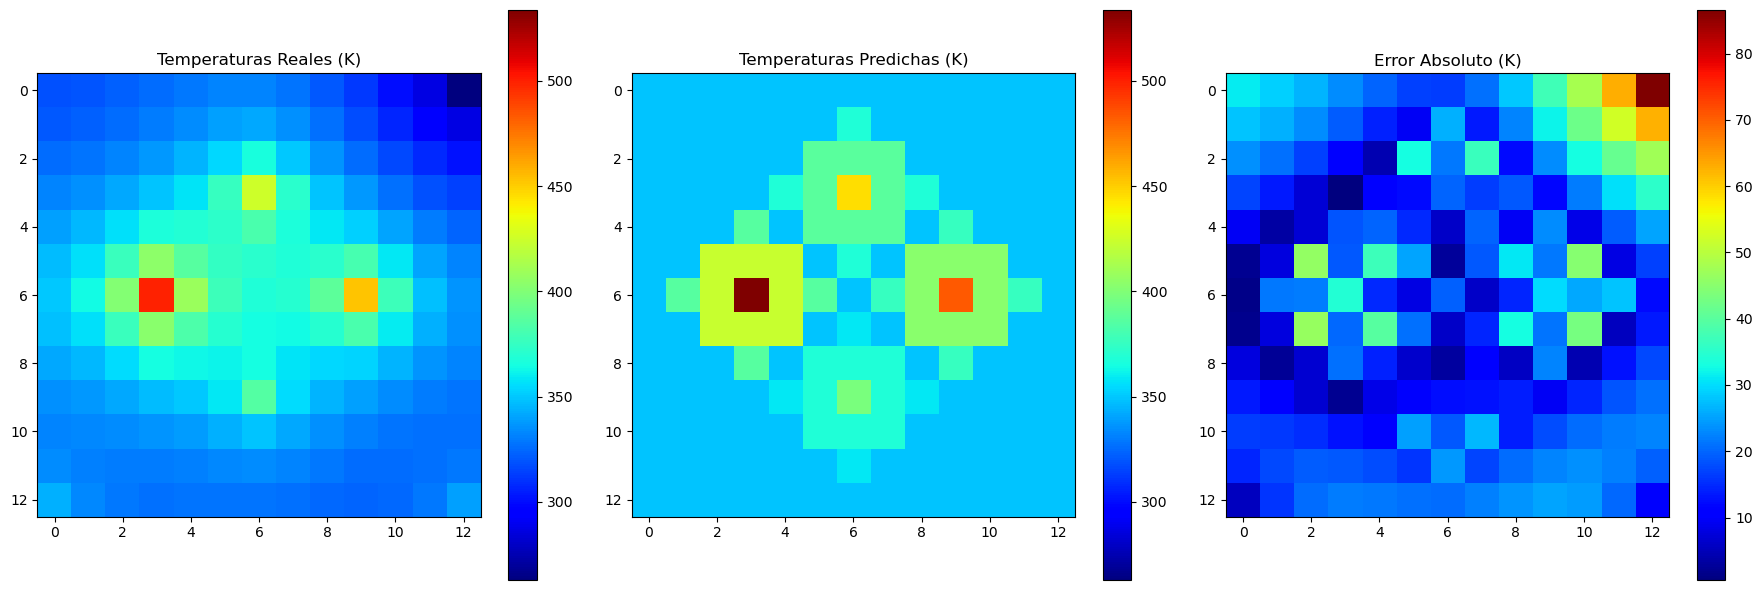

Test MSE: 640.1271 - Test MAE: 20.0327 - Test R2: 0.0831
Porcentaje de nodos correctamente predichos dentro de ±5.0 K: 15.65%


In [9]:
# Evaluación en el conjunto de prueba
print("Evaluando en el conjunto de prueba...")

if use_memory_for_best_model and best_model_state is not None:
    model.load_state_dict(best_model_state)
    print("Evaluando el mejor modelo encontrado en memoria...")

if config["use_percentage_threshold"]:
    test_mse, test_mae, test_r2, test_accuracy = evaluate(
        model, test_loader, device, nodos_por_grafico=nodos_por_grafico,
        percentage_threshold=config["percentage_threshold"],
        plot_results=True,
        normalize=False
    )
else:
    test_mse, test_mae, test_r2, test_accuracy = evaluate(
        model, test_loader, device, nodos_por_grafico=nodos_por_grafico,
        error_threshold=config["error_threshold_K"],
        plot_results=True,
        normalize=False
    )

# Mostrar resultados
print(f"Test MSE: {test_mse:.4f} - Test MAE: {test_mae:.4f} - Test R2: {test_r2:.4f}")
if config["use_percentage_threshold"]:
    print(f"Porcentaje de nodos correctamente predichos: {test_accuracy:.2f}%")
else:
    print(f"Porcentaje de nodos correctamente predichos dentro de ±{config['error_threshold_K']} K: {test_accuracy:.2f}%")

# Guardar el mejor modelo si se desea, o el último modelo si no se usa memoria
if save_model_to_file:
    if use_memory_for_best_model and best_model_state is not None:
        model.load_state_dict(best_model_state)
        print("Guardando el mejor modelo en archivo...")
    else:
        print("Guardando el último modelo entrenado en archivo...")

    save_model(
        model, num_layers=num_layers, hidden_dim=hidden_dim, 
        epochs=epochs, learning_rate=learning_rate,
        test_mse=test_mse, test_accuracy=test_accuracy
    )

Si quisieramos predecir las temperaturas sin tener un target, pero si un archivo con las condiciones de contorno, compilariamos el siguiente bloque de código.

In [10]:
""" from train_eval import predict  # Asegúrate que la función predict() está disponible

# Cargar las condiciones de contorno (sin target)
conditions = load_pcb_dataset('conditions.pth') # Asegúrate que el archivo 'conditions.pth' está en la carpeta actual
conditions_loader = DataLoader(conditions, batch_size=32, shuffle=False)

# Generar predicciones
predictions = predict(model, conditions_loader, device, nodos_por_grafico=nodos_por_grafico, normalize=False)

# Guardar las predicciones si lo deseas
torch.save(predictions, "Predicciones_Condiciones.pth")
print("Predicciones generadas y guardadas correctamente.")

plot_temperature_maps(predictions[0])  # Cambiar el índice si deseas visualizar otro gráfico
 """


' from train_eval import predict  # Asegúrate que la función predict() está disponible\n\n# Cargar las condiciones de contorno (sin target)\nconditions = load_pcb_dataset(\'conditions.pth\') # Asegúrate que el archivo \'conditions.pth\' está en la carpeta actual\nconditions_loader = DataLoader(conditions, batch_size=32, shuffle=False)\n\n# Generar predicciones\npredictions = predict(model, conditions_loader, device, nodos_por_grafico=nodos_por_grafico, normalize=False)\n\n# Guardar las predicciones si lo deseas\ntorch.save(predictions, "Predicciones_Condiciones.pth")\nprint("Predicciones generadas y guardadas correctamente.")\n\nplot_temperature_maps(predictions[0])  # Cambiar el índice si deseas visualizar otro gráfico\n '